# TVDI（Temperature vegetation dryness index）

In [1]:
import os
# 对应自己的python包的安装地址
os.environ['PROJ_LIB'] = r'D:\ProgramData\Anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj' 
from osgeo import gdal,osr

In [2]:
#  gdal打开hdf数据集
datasets = gdal.Open(r"Data\MOD13A3\2012\MOD13A3.A2012001.h26v04.005.hdf")

#  获取hdf中的子数据集
SubDatasets = datasets.GetSubDatasets()
#  获取子数据集的个数
SubDatasetsNum =  len(datasets.GetSubDatasets())
#  输出各子数据集的信息
print("子数据集一共有{0}个: ".format(SubDatasetsNum))
for i in range(SubDatasetsNum):
    print(datasets.GetSubDatasets()[i])

子数据集一共有11个: 
('HDF4_EOS:EOS_GRID:"Data\\MOD13A3\\2012\\MOD13A3.A2012001.h26v04.005.hdf":MOD_Grid_monthly_1km_VI:"1 km monthly NDVI"', '[1200x1200] 1 km monthly NDVI MOD_Grid_monthly_1km_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"Data\\MOD13A3\\2012\\MOD13A3.A2012001.h26v04.005.hdf":MOD_Grid_monthly_1km_VI:"1 km monthly EVI"', '[1200x1200] 1 km monthly EVI MOD_Grid_monthly_1km_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"Data\\MOD13A3\\2012\\MOD13A3.A2012001.h26v04.005.hdf":MOD_Grid_monthly_1km_VI:"1 km monthly VI Quality"', '[1200x1200] 1 km monthly VI Quality MOD_Grid_monthly_1km_VI (16-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"Data\\MOD13A3\\2012\\MOD13A3.A2012001.h26v04.005.hdf":MOD_Grid_monthly_1km_VI:"1 km monthly red reflectance"', '[1200x1200] 1 km monthly red reflectance MOD_Grid_monthly_1km_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"Data\\MOD13A3\\2012\\MOD13A3.A2012001.h26v04.005.hdf":MOD_Grid_monthly_1km_VI:"1 km monthly NIR reflectance"', '[1200x1200] 1 km monthly NIR refl

In [3]:
#  获取hdf中的元数据
Metadata = datasets.GetMetadata()
#  获取元数据的个数
MetadataNum = len(Metadata)
#  输出各子数据集的信息
print("元数据一共有{0}个: ".format(MetadataNum))
for key,value in Metadata.items():
    print('{key}:{value}'.format(key = key, value = value))

元数据一共有163个: 
ALGORITHMPACKAGEACCEPTANCEDATE:102004
ALGORITHMPACKAGEMATURITYCODE:Normal
ALGORITHMPACKAGENAME:MOD_PR13A3
ALGORITHMPACKAGEVERSION:5
ASSOCIATEDINSTRUMENTSHORTNAME.1:MODIS
ASSOCIATEDPLATFORMSHORTNAME.1:Terra
ASSOCIATEDSENSORSHORTNAME.1:MODIS
AUTOMATICQUALITYFLAG.1:Passed
AUTOMATICQUALITYFLAG.10:Passed
AUTOMATICQUALITYFLAG.11:Passed
AUTOMATICQUALITYFLAG.2:Passed
AUTOMATICQUALITYFLAG.3:Passed
AUTOMATICQUALITYFLAG.4:Passed
AUTOMATICQUALITYFLAG.5:Passed
AUTOMATICQUALITYFLAG.6:Passed
AUTOMATICQUALITYFLAG.7:Passed
AUTOMATICQUALITYFLAG.8:Passed
AUTOMATICQUALITYFLAG.9:Passed
AUTOMATICQUALITYFLAGEXPLANATION.1:No automatic quality assessment is performed in the PGE
AUTOMATICQUALITYFLAGEXPLANATION.10:No automatic quality assessment is performed in the PGE
AUTOMATICQUALITYFLAGEXPLANATION.11:No automatic quality assessment is performed in the PGE
AUTOMATICQUALITYFLAGEXPLANATION.2:No automatic quality assessment is performed in the PGE
AUTOMATICQUALITYFLAGEXPLANATION.3:No automatic qualit

In [4]:
import os
import numpy as np

#  写入tif函数
def array2raster(TifName, GeoTransform, array):
    cols = array.shape[1]  # 矩阵列数
    rows = array.shape[0]  # 矩阵行数
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(TifName, cols, rows, 1, gdal.GDT_Float32)
    # 括号中两个0表示起始像元的行列号从(0,0)开始
    outRaster.SetGeoTransform(tuple(GeoTransform))
    # 获取数据集第一个波段，是从1开始，不是从0开始
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    # 4326表示WGS84坐标
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

#  hdf批量转tif
def hdf2tif_batch(hdfFolder, SaveFolder):
    #  获取文件夹内的文件名
    hdfNameList = os.listdir(hdfFolder)
    for i in range(len(hdfNameList)):
        #  判断当前文件是否为HDF文件
        if(os.path.splitext(hdfNameList[i])[1] == ".hdf"):
            hdfPath = hdfFolder+"/"+hdfNameList[i]
            #  gdal打开hdf数据集
            datasets = gdal.Open(hdfPath)
            
            #  第一个子数据集合,也就是NDVI数据
            DatasetNDVI = datasets.GetSubDatasets()[0][0]
            RasterNDVI = gdal.Open(DatasetNDVI)
            NDVI = RasterNDVI.ReadAsArray()
            
            #  获取hdf中的元数据
            Metadata = datasets.GetMetadata()
            #  获取四个角的维度
            Latitudes = Metadata["GRINGPOINTLATITUDE.1"]
            #  采用", "进行分割
            LatitudesList = Latitudes.split(", ")
            #  获取四个角的经度
            Longitude = Metadata["GRINGPOINTLONGITUDE.1"]
            #  采用", "进行分割
            LongitudeList = Longitude.split(", ")

            # 图像四个角的地理坐标
            GeoCoordinates = np.zeros((4, 2), dtype = "float32")
            GeoCoordinates[0] = np.array([float(LongitudeList[0]),float(LatitudesList[0])])
            GeoCoordinates[1] = np.array([float(LongitudeList[1]),float(LatitudesList[1])])
            GeoCoordinates[2] = np.array([float(LongitudeList[2]),float(LatitudesList[2])])
            GeoCoordinates[3] = np.array([float(LongitudeList[3]),float(LatitudesList[3])])

            #  列数
            Columns = NDVI.shape[0]
            #  行数
            Rows = NDVI.shape[1]
            #  图像四个角的图像坐标
            PixelCoordinates = np.array([[0, 0],
                                         [Columns - 1, 0],
                                         [Columns - 1, Rows - 1],
                                         [0, Rows - 1]], dtype = "float32")
    
            #  计算仿射变换矩阵
            from scipy.optimize import leastsq
            def func(i):
                Transform0, Transform1, Transform2, Transform3, Transform4, Transform5 = i[0], i[1], i[2], i[3], i[4], i[5]
                return [Transform0 + PixelCoordinates[0][0] * Transform1 + PixelCoordinates[0][1] * Transform2 - GeoCoordinates[0][0],
                        Transform3 + PixelCoordinates[0][0] * Transform4 + PixelCoordinates[0][1] * Transform5 - GeoCoordinates[0][1],
                        Transform0 + PixelCoordinates[1][0] * Transform1 + PixelCoordinates[1][1] * Transform2 - GeoCoordinates[1][0],
                        Transform3 + PixelCoordinates[1][0] * Transform4 + PixelCoordinates[1][1] * Transform5 - GeoCoordinates[1][1],
                        Transform0 + PixelCoordinates[2][0] * Transform1 + PixelCoordinates[2][1] * Transform2 - GeoCoordinates[2][0],
                        Transform3 + PixelCoordinates[2][0] * Transform4 + PixelCoordinates[2][1] * Transform5 - GeoCoordinates[2][1],
                        Transform0 + PixelCoordinates[3][0] * Transform1 + PixelCoordinates[3][1] * Transform2 - GeoCoordinates[3][0],
                        Transform3 + PixelCoordinates[3][0] * Transform4 + PixelCoordinates[3][1] * Transform5 - GeoCoordinates[3][1]]
            #  最小二乘法求解
            GeoTransform = leastsq(func,np.asarray((1,1,1,1,1,1)))

            #  获取数据时间
            date = Metadata["RANGEBEGINNINGDATE"]
            
            TifName = SaveFolder + "/" + date + ".tif"
            array2raster(TifName, GeoTransform[0], NDVI)
            print(TifName,"转换成功！")
            

In [5]:
hdf2tif_batch(r"Data\MOD13A3\2012", r"Data\MOD13A3\NDVItif")

Data\MOD13A3\NDVItif/2012-01-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-02-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-03-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-04-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-05-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-06-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-07-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-08-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-09-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-10-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-11-01.tif 转换成功！
Data\MOD13A3\NDVItif/2012-12-01.tif 转换成功！


In [6]:
hdf2tif_batch(r"Data\MOD11A2\2012", r"Data\MOD11A2\LSTtif")

Data\MOD11A2\LSTtif/2012-01-01.tif 转换成功！
Data\MOD11A2\LSTtif/2012-01-09.tif 转换成功！
Data\MOD11A2\LSTtif/2012-01-17.tif 转换成功！
Data\MOD11A2\LSTtif/2012-01-25.tif 转换成功！
Data\MOD11A2\LSTtif/2012-02-02.tif 转换成功！
Data\MOD11A2\LSTtif/2012-02-10.tif 转换成功！
Data\MOD11A2\LSTtif/2012-02-18.tif 转换成功！
Data\MOD11A2\LSTtif/2012-02-26.tif 转换成功！
Data\MOD11A2\LSTtif/2012-03-05.tif 转换成功！
Data\MOD11A2\LSTtif/2012-03-13.tif 转换成功！
Data\MOD11A2\LSTtif/2012-03-21.tif 转换成功！
Data\MOD11A2\LSTtif/2012-03-29.tif 转换成功！
Data\MOD11A2\LSTtif/2012-04-06.tif 转换成功！
Data\MOD11A2\LSTtif/2012-04-14.tif 转换成功！
Data\MOD11A2\LSTtif/2012-04-22.tif 转换成功！
Data\MOD11A2\LSTtif/2012-04-30.tif 转换成功！
Data\MOD11A2\LSTtif/2012-05-08.tif 转换成功！
Data\MOD11A2\LSTtif/2012-05-16.tif 转换成功！
Data\MOD11A2\LSTtif/2012-05-24.tif 转换成功！
Data\MOD11A2\LSTtif/2012-06-01.tif 转换成功！
Data\MOD11A2\LSTtif/2012-06-09.tif 转换成功！
Data\MOD11A2\LSTtif/2012-06-17.tif 转换成功！
Data\MOD11A2\LSTtif/2012-06-25.tif 转换成功！
Data\MOD11A2\LSTtif/2012-07-03.tif 转换成功！
Data\MOD11A2\LST

In [7]:
#  先裁剪dem
File = r"Data\DEM\srtm_60_04.img"
dataset =  gdal.Open(File)
gdal.Warp(r"Data\DEM\DEM_warp.tif",
          dataset,
          width = 455,
          height = 443,
          cutlineDSName = r"Data\Mask\mask.shp",
          cropToCutline = True)
print("DEM_warp.tif 裁剪重采样成功！")

DEM_warp.tif 裁剪重采样成功！


In [8]:
#  批量重采样
def Resample_batch(tifFolder, SaveFloder, suffix):
    #  获取文件夹内的文件名
    tifNameList = os.listdir(tifFolder)
    for i in range(len(tifNameList)):
        #  判断当前文件是否为tif文件
        if(os.path.splitext(tifNameList[i])[1] == ".tif"):
            tifPath = tifFolder+"/"+tifNameList[i]
            dataset =  gdal.Open(tifPath)
            SavePath = SaveFloder + "/" + os.path.splitext(tifNameList[i])[0] + suffix + ".tif"
            gdal.Warp(SavePath,
                      dataset,
                      width = 455,
                      height = 443,
                      cutlineDSName = r"Data\Mask\mask.shp",
                      cropToCutline = True)
            print(SavePath+" 裁剪重采样成功!")

In [9]:
#  批量重采样NDVI
Resample_batch(r"Data\MOD13A3\NDVItif", r"Data\MOD13A3\NDVItif_wrap", "_wrap")

Data\MOD13A3\NDVItif_wrap/2012-01-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-02-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-03-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-04-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-05-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-06-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-07-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-08-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-09-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-10-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-11-01_wrap.tif 裁剪重采样成功!
Data\MOD13A3\NDVItif_wrap/2012-12-01_wrap.tif 裁剪重采样成功!


In [10]:
#  批量重采样LST
Resample_batch(r"Data\MOD11A2\LSTtif", r"Data\MOD11A2\LSTtif_wrap", "_wrap")

Data\MOD11A2\LSTtif_wrap/2012-01-01_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-01-09_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-01-17_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-01-25_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-02-02_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-02-10_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-02-18_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-02-26_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-03-05_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-03-13_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-03-21_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-03-29_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-04-06_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-04-14_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-04-22_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-04-30_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-05-08_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/2012-05-16_wrap.tif 裁剪重采样成功!
Data\MOD11A2\LSTtif_wrap/201

In [11]:
import math

#读取tif数据集
def readTif(fileName):
    dataset = gdal.Open(fileName)
    if dataset == None:
        print(fileName+"文件无法打开")
    return dataset

#保存tif文件函数
def writeTiff(im_data,im_geotrans,im_proj,path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape
    #创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #写入仿射变换参数
        dataset.SetProjection(im_proj) #写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset

#  批量平均值插值
def SpatialInterpolation_batch(tifFolder, FillValue, SaveFolder, suffix, ScaleFactor):
    #  获取文件夹内的文件名
    tifNameList = os.listdir(tifFolder)
    for i in range(len(tifNameList)):
        #  判断当前文件是否为tif文件
        if(os.path.splitext(tifNameList[i])[1] == ".tif"):
            tifPath = tifFolder + "/" + tifNameList[i]
            dataset = readTif(tifPath)
            width = dataset.RasterXSize #栅格矩阵的列数
            height = dataset.RasterYSize #栅格矩阵的行数
            Tif_geotrans = dataset.GetGeoTransform()
            Tif_proj = dataset.GetProjection()
            Tif_data = dataset.ReadAsArray(0,0,width,height)#获取数据

            mean = np.mean(Tif_data)
            for j in range(Tif_data.shape[0]):
                for k in range(Tif_data.shape[1]):
                    if(math.isclose(Tif_data[j][k], FillValue)):
                        Tif_data[j][k] = mean
            
            Tif_data = Tif_data * ScaleFactor
            Savepath = SaveFolder + "/" + os.path.splitext(tifNameList[i])[0] + suffix + ".tif"
            writeTiff(Tif_data,Tif_geotrans,Tif_proj,Savepath)
            print(Savepath +" 插值成功!")
            
#  NDVI插值
SpatialInterpolation_batch(r"Data\MOD13A3\NDVItif_wrap", -3000, 
                           r"Data\MOD13A3\NDVItif_warp_SpatialIinterpolation", "_SpatialIinterpolation", 0.0001)
#  LST插值
SpatialInterpolation_batch(r"Data\MOD11A2\LSTtif_wrap", 0, 
                           r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation", "_SpatialIinterpolation", 0.02)

Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-01-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-02-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-03-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-04-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-05-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-06-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-07-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-08-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-09-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation/2012-10-01_wrap_SpatialIinterpolation.tif 插值成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterp

In [12]:
#  S-G滤波
from scipy.signal import savgol_filter 
def SG_filter(tifFolder, SaveFolder, suffix):
    '''
    tifFolder tif所在文件夹
    suffix 生成结果文件名后缀
    '''
    #  获取文件夹内的文件名
    tifNameList = os.listdir(tifFolder)
    tifPath = tifFolder + "/" + tifNameList[0]
    dataset = readTif(tifPath)
    width = dataset.RasterXSize #栅格矩阵的列数
    height = dataset.RasterYSize #栅格矩阵的行数
    Tif_geotrans = dataset.GetGeoTransform()
    Tif_proj = dataset.GetProjection()
    Tif_data = dataset.ReadAsArray(0,0,width,height)#获取数据
    Tif_datas = np.zeros((len(tifNameList), Tif_data.shape[0], Tif_data.shape[1]))
    for i in range(len(tifNameList)):
        tifPath = tifFolder + "/" + tifNameList[i]
        dataset = readTif(tifPath)
        Tif_data = dataset.ReadAsArray(0,0,width,height)#获取数据
        Tif_datas[i] = Tif_data
    #  维度切换，便于后面的提取每个像素对应的各个时期值
    Tif_datas = Tif_datas.swapaxes(1,0)
    Tif_datas = Tif_datas.swapaxes(1,2)
    
    SGfilter = np.zeros(Tif_datas.shape)
    #  计算每个位置的栅格的SG滤波
    for i in range(Tif_datas.shape[0]):
        for j in range(Tif_datas.shape[1]):
            SGfilter[i][j] = savgol_filter(Tif_datas[i][j], window_length=7, polyorder=2) 
    #  维度切换回去
    SGfilter = SGfilter.swapaxes(1,0)
    SGfilter = SGfilter.swapaxes(0,2)
    
    for i in range(SGfilter.shape[0]):
        SavePath = SaveFolder + "/" + os.path.splitext(tifNameList[i])[0] + suffix + ".tif"
        writeTiff(SGfilter[i], Tif_geotrans, Tif_proj, SavePath)
        print(SavePath +" S-G滤波成功!")

#  对NDVI进行SG滤波
SG_filter(r"Data\MOD13A3\NDVItif_warp_SpatialIinterpolation", r"Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter", "_SGfilter")
#  对LST进行SG滤波
SG_filter(r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation", r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter", "_SGfilter")

Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-01-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-02-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-03-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-04-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-05-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-06-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-07-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-08-01_wrap_SpatialIinterpolation_SGfilter.tif S-G滤波成功!
Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter/2012-09

In [13]:
#  LST的地形校正
def LSTCorrection(LSTFolder, DEMPath, SaveFloder, suffix, a, b, c):
    dataset = readTif(DEMPath)
    width = dataset.RasterXSize #栅格矩阵的列数
    height = dataset.RasterYSize #栅格矩阵的行数
    DEM_geotrans = dataset.GetGeoTransform()
    DEM_proj = dataset.GetProjection()
    DEM_data = dataset.ReadAsArray(0,0,width,height)#获取数据
    #  获取文件夹内的文件名
    LSTNameList = os.listdir(LSTFolder)
    for i in range(len(LSTNameList)):
        LSTPath = LSTFolder + "/" + LSTNameList[i]
        dataset = readTif(LSTPath)
        LST_data = dataset.ReadAsArray(0,0,width,height)#获取数据
        
        LSTCorr = np.zeros(LST_data.shape)
        for j in range(LST_data.shape[0]):
            for k in range(LST_data.shape[1]):
                #  根据仿射变换矩阵计算纬度
                Latitude = DEM_geotrans[3] + DEM_geotrans[4] * j + DEM_geotrans[5] * k
                #  根据公式校正LST
                LSTCorr[j][k] = LST_data[j][k] + a * DEM_data[j][k] + b * Latitude + c
        SavePath = SaveFloder + "/" + os.path.splitext(LSTNameList[i])[0] + suffix + ".tif"
        writeTiff(LSTCorr,DEM_geotrans,DEM_proj,SavePath)
        print(SavePath + "校正成功！")
        
LSTCorrection(r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter",
              r"Data\DEM\DEM_warp.tif",
              r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr",
              "_Correction", 0.006, 0.4, -16)

Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-01-01_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-01-09_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-01-17_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-01-25_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-02-02_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-02-10_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-02-18_wrap_SpatialIinterpolation_SGfilter_Correction.tif校正成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr/2012-02-26_wrap_SpatialIinterpolation_SGfil

In [14]:
#  月度平均
def MonthlyAverage(tifFolder, SaveFolder, suffix):
    '''
    tifFolder tif所在文件夹
    suffix 生成结果文件名后缀
    '''
    #  获取文件夹内的文件名
    tifNameList = os.listdir(tifFolder)
    #  获取文件的月份
    YearMonthList = []
    for i in range(len(tifNameList)):
        #  我的文件名前七位为年-月,比如2012-06
        YearMonth = tifNameList[i][0:7]
        YearMonthList.append(YearMonth)
    #  去除重复值
    YearMonthList = list(set(YearMonthList))
    #  匹配每个月份的对应文件进行平均值运算
    for i in range(len(YearMonthList)):
        tifPath = tifFolder + "/" + tifNameList[0]
        dataset = readTif(tifPath)
        width = dataset.RasterXSize #栅格矩阵的列数
        height = dataset.RasterYSize #栅格矩阵的行数
        Tif_geotrans = dataset.GetGeoTransform()
        Tif_proj = dataset.GetProjection()
        data_sum = np.zeros((height, width))
        count = 0
        for j in range(len(tifNameList)):
            if(tifNameList[j][0:7] == YearMonthList[i]):
                tifPath = tifFolder + "/" + tifNameList[j]
                dataset = readTif(tifPath)
                Tif_data = dataset.ReadAsArray(0,0,width,height)#获取数据
                data_sum = data_sum + Tif_data
                count = count + 1
        MonthlyAverage = data_sum / count
        SavePath = SaveFolder + "/" + YearMonthList[i] + suffix + ".tif";
        writeTiff(MonthlyAverage,Tif_geotrans,Tif_proj,SavePath)
        print(SavePath, " 月度数据生成成功！")

MonthlyAverage(r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr",
               r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month", "Month")

Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-04Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-08Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-05Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-09Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-10Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-07Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-01Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-06Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-02Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month/2012-11Month.tif  月度数据生成成功！
Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGF

2012-01
读取输入栅格数据信息...
干边、湿边拟合...


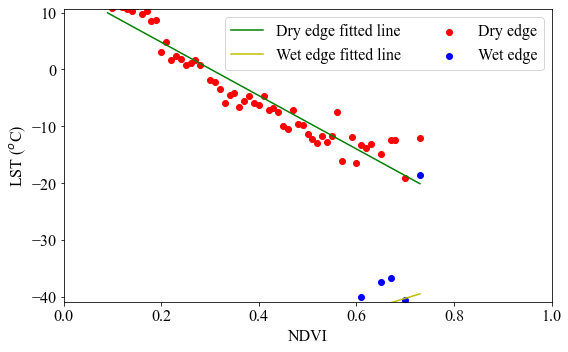

干边拟合方程：y = -46.996x + 14.188，r2 = 0.910
湿边拟合方程：y = 26.093x + -58.581，r2 = 0.644
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-01TVDI.tif'

2012-02
读取输入栅格数据信息...
干边、湿边拟合...


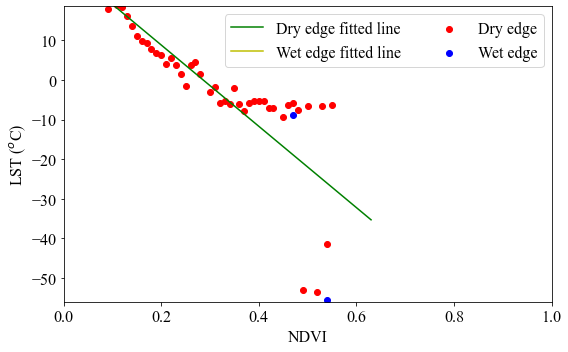

干边拟合方程：y = -102.549x + 29.306，r2 = 0.648
湿边拟合方程：y = 31.572x + -79.135，r2 = 0.207
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-02TVDI.tif'

2012-03
读取输入栅格数据信息...
干边、湿边拟合...


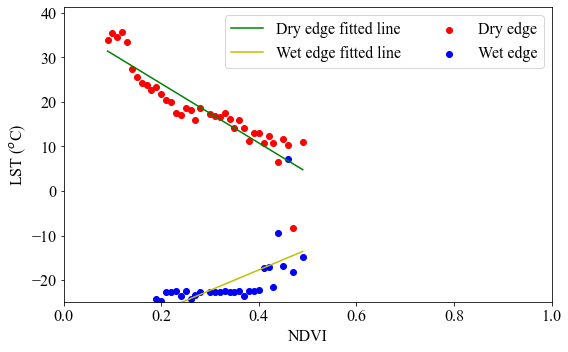

干边拟合方程：y = -66.582x + 37.412，r2 = 0.816
湿边拟合方程：y = 46.028x + -36.112，r2 = 0.601
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-03TVDI.tif'

2012-04
读取输入栅格数据信息...
干边、湿边拟合...


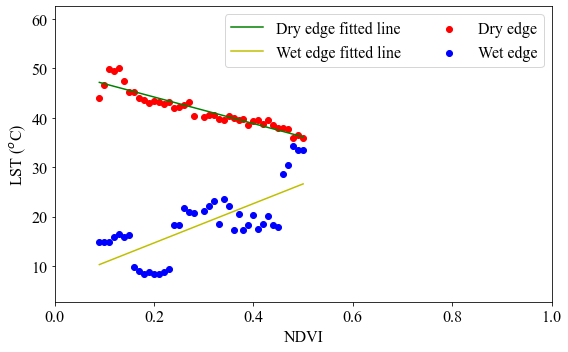

干边拟合方程：y = -26.909x + 49.606，r2 = 0.858
湿边拟合方程：y = 39.861x + 6.693，r2 = 0.524
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-04TVDI.tif'

2012-05
读取输入栅格数据信息...
干边、湿边拟合...


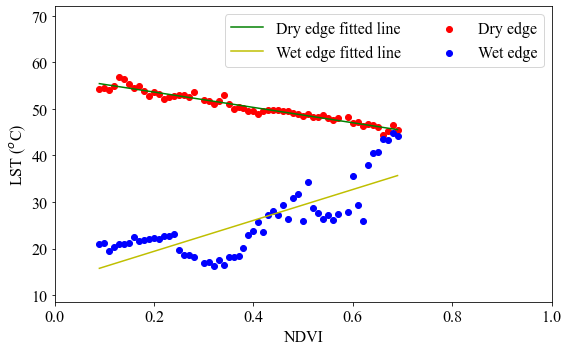

干边拟合方程：y = -16.493x + 56.925，r2 = 0.942
湿边拟合方程：y = 33.226x + 12.750，r2 = 0.617
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-05TVDI.tif'

2012-06
读取输入栅格数据信息...
干边、湿边拟合...


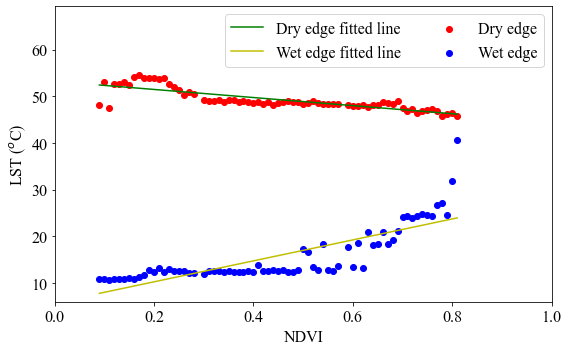

干边拟合方程：y = -8.661x + 53.181，r2 = 0.669
湿边拟合方程：y = 22.441x + 5.765，r2 = 0.660
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-06TVDI.tif'

2012-07
读取输入栅格数据信息...
干边、湿边拟合...


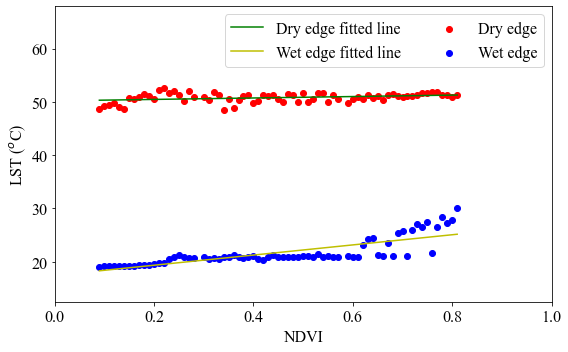

干边拟合方程：y = 1.349x + 50.194，r2 = 0.104
湿边拟合方程：y = 9.534x + 17.437，r2 = 0.624
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-07TVDI.tif'

2012-08
读取输入栅格数据信息...
干边、湿边拟合...


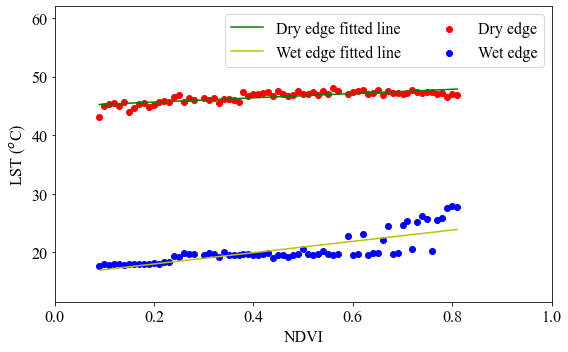

干边拟合方程：y = 3.645x + 44.922，r2 = 0.631
湿边拟合方程：y = 9.650x + 16.105，r2 = 0.615
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-08TVDI.tif'

2012-09
读取输入栅格数据信息...
干边、湿边拟合...


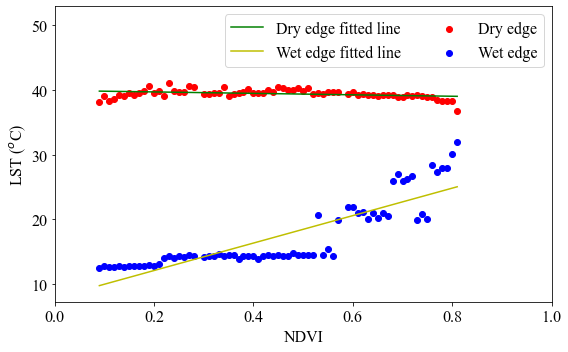

干边拟合方程：y = -1.114x + 39.946，r2 = 0.125
湿边拟合方程：y = 21.242x + 7.841，r2 = 0.736
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-09TVDI.tif'

2012-10
读取输入栅格数据信息...
干边、湿边拟合...


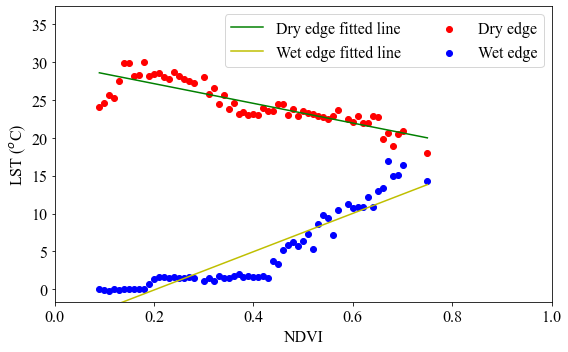

干边拟合方程：y = -13.012x + 29.748，r2 = 0.734
湿边拟合方程：y = 25.281x + -5.148，r2 = 0.844
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-10TVDI.tif'

2012-11
读取输入栅格数据信息...
干边、湿边拟合...


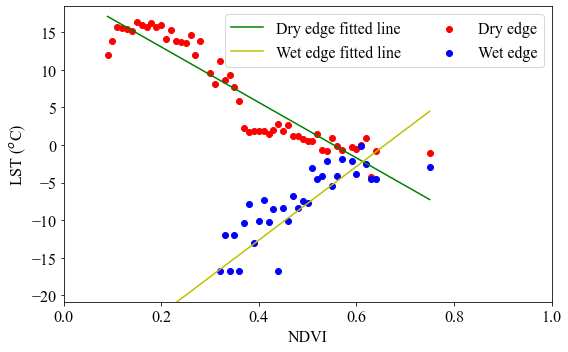

干边拟合方程：y = -36.894x + 20.420，r2 = 0.869
湿边拟合方程：y = 48.936x + -32.224，r2 = 0.888
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-11TVDI.tif'

2012-12
读取输入栅格数据信息...
干边、湿边拟合...


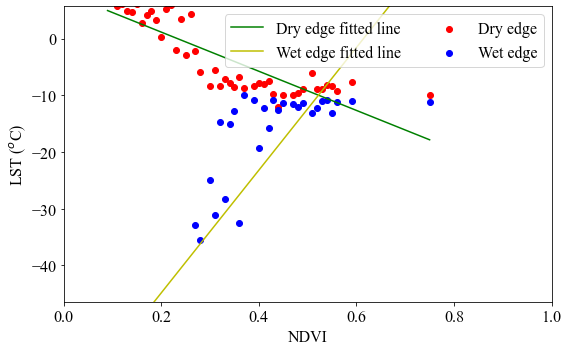

干边拟合方程：y = -34.546x + 8.076，r2 = 0.730
湿边拟合方程：y = 108.248x + -66.502，r2 = 0.809
计算TVDI...
计算完成,保存为 'Data/TVDIResult/2012-12TVDI.tif'



In [15]:
import matplotlib.pyplot as plt
def calTVDI(NDVIPath, LSTPath, NDVI_range, outfig, SavePath):
    # 读取输入栅格数据信息
    print("读取输入栅格数据信息...")
    dataset = readTif(NDVIPath)
    width = dataset.RasterXSize #栅格矩阵的列数
    height = dataset.RasterYSize #栅格矩阵的行数
    NDVI_geotrans = dataset.GetGeoTransform()
    NDVI_proj = dataset.GetProjection()
    NDVI = dataset.ReadAsArray(0,0,width,height)#获取数据
    dataset = readTif(LSTPath)
    LST = dataset.ReadAsArray(0,0,width,height)#获取数据
    LST = LST - 273
 
    abcd = edge(NDVI, LST, NDVI_range, outfig)
    a = abcd[0][0]
    b = abcd[0][1]
    c = abcd[1][0]
    d = abcd[1][1]
    print("干边拟合方程：y = %.3fx + %.3f，r2 = %.3f" % (a, b, abcd[0][2] * abcd[0][2]))
    print("湿边拟合方程：y = %.3fx + %.3f，r2 = %.3f" % (c, d, abcd[1][2] * abcd[1][2]))
    print("计算TVDI...")
    TVDI = np.zeros(NDVI.shape)
    for m in range(NDVI.shape[0]):
        for n in range(NDVI.shape[1]):
            TVDI[m][n] = (LST[m][n] - (abcd[1][0] * NDVI[m][n] + abcd[1][1])) / ((abcd[0][0] * NDVI[m][n] + abcd[0][1]) - (abcd[1][0] * NDVI[m][n] + abcd[1][1]))
    TVDI[TVDI < 0] = 0
    TVDI[TVDI > 1] = 1
    #  保存TVDI
    writeTiff(TVDI,NDVI_geotrans,NDVI_proj,SavePath)
    print("计算完成,保存为 '%s'\n" % SavePath)
 
 
def edge(NDVI, LST, NDVI_range, outfig):
    print("干边、湿边拟合...")
    edgeArr = [[] for _ in range(99)]
    for i in range(NDVI.shape[0]):
        for j in range(NDVI.shape[1]):
            if NDVI[i][j] > NDVI_range[0] - 0.01 and NDVI[i][j] < NDVI_range[1] + 0.01:
                k = '%.2f' % NDVI[i][j]
                edgeArr[int(float(k) * 100)].append(LST[i][j])
         
    # 排序，寻找干边湿边
    eMax = []
    NDVISort = []
    eMin = []
    for n in range(len(edgeArr)):
        edgeSort = np.sort(edgeArr[n])
        if len(edgeSort) > 1:
            eMax.append(edgeSort[-1])
            eMin.append(edgeSort[0])
            NDVISort.append(float(n) / 100.)
    
    fitMax = linefit(NDVISort, eMax)
    fitMin = linefit(NDVISort, eMin)

    # 作图
    createPlot(NDVISort, eMax, eMin, [fitMax, fitMin], outfig)
 
    return [fitMax, fitMin]

#  拟合方程
def linefit(x, y):
    N = float(len(x))
    sx, sy, sxx, syy, sxy = 0, 0, 0, 0, 0
    for i in range(0,int(N)):
        sx += x[i]
        sy += y[i]
        sxx += x[i] * x[i]
        syy += y[i] * y[i]
        sxy += x[i] * y[i]
    a = (sy * sx / N - sxy) / ( sx * sx / N - sxx)
    b = (sy - a*sx)/N
    r = abs(sy * sx / N - sxy) / math.sqrt((sxx - sx * sx / N) * (syy - sy * sy / N))
    return [a, b, r]
 
#  绘制干边湿边拟合图
def createPlot(NDVI, emax, emin, abcd, outfig):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.tick_params(labelsize=16)

    #  设置y轴、x轴上下限
    ylimit_min = np.min(emin) - 0.3 * np.average(emin)
    ylimit_max = np.max(emax) + 0.3 * np.average(emax)
    plt.ylim(ylimit_min, ylimit_max)
    plt.xlim(0, 1)
    
    #  画出干边湿边的拟合方程
    cof = np.polyfit(NDVI, emax, 1)
    p = np.poly1d(cof)
    plt.plot(NDVI, p(NDVI), label='Dry edge fitted line', c='g')
    cof = np.polyfit(NDVI, emin, 1)
    p = np.poly1d(cof)
    plt.plot(NDVI, p(NDVI), label='Wet edge fitted line', c='y')
    
    #  画出干边湿边的散点
    plt.scatter(NDVI, emax, label='Dry edge', c = 'r')
    plt.scatter(NDVI, emin, label='Wet edge', c = 'b')
    
    #  设置y轴、x轴标注
    ax.set_xlabel('NDVI', fontsize=16)
    ax.set_ylabel('LST ($^o$C)', fontsize=16)
    plt.legend(fontsize=16, loc='upper right', ncol=2)
    fig.tight_layout()
    plt.savefig(outfig, dpi=300)
    plt.show()
    
## 有效NDVI
NDVI_range = [0.1, 0.8]
NDVIFolder = r"Data\MOD13A3\NDVItif_warp_SpatialIinterpolation_SGFilter"
LSTFolder = r"Data\MOD11A2\LSTtif_warp_SpatialIinterpolation_SGFilter_Corr_Month"

NDVINameList = os.listdir(NDVIFolder)
for i in range(len(NDVINameList)):
    print(NDVINameList[i][0:7])
    print("==========================")
    NDVIPath = NDVIFolder + "/" + NDVINameList[i]
    LSTPath = LSTFolder + "/" + NDVINameList[i][0:7] + "Month.tif"
    outfig = "Data/FittedLine/" + NDVINameList[i][0:7] + ".png"
    SavePath = "Data/TVDIResult/" + NDVINameList[i][0:7] + "TVDI.tif"
    calTVDI(NDVIPath, LSTPath, NDVI_range, outfig, SavePath)

2012-01


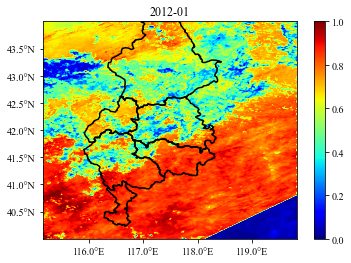

2012-02


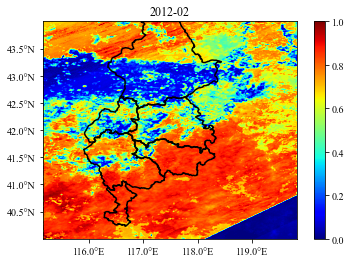

2012-03


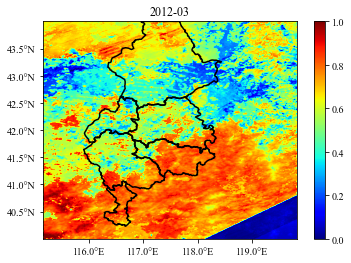

2012-04


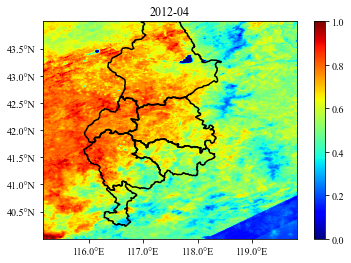

2012-05


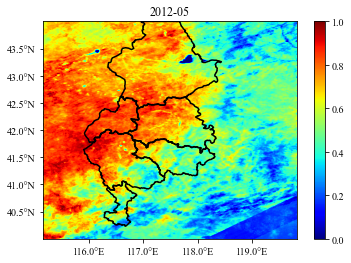

2012-06


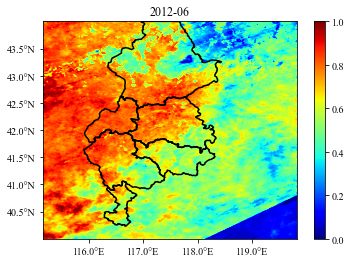

2012-07


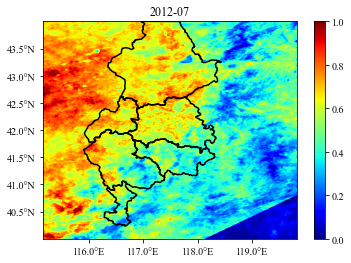

2012-08


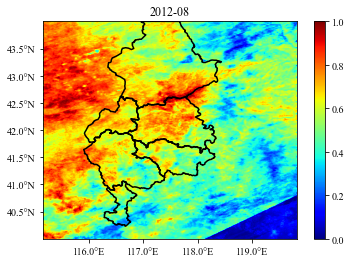

2012-09


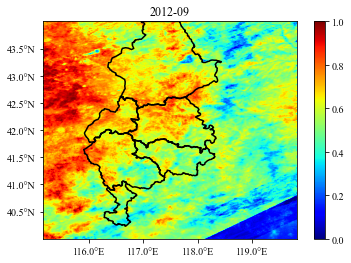

2012-10


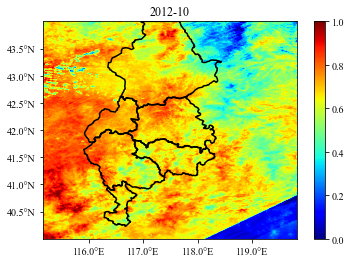

2012-11


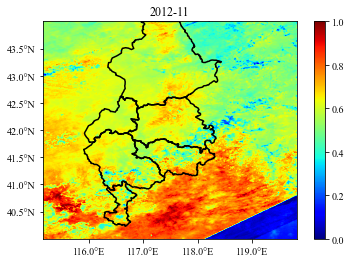

2012-12


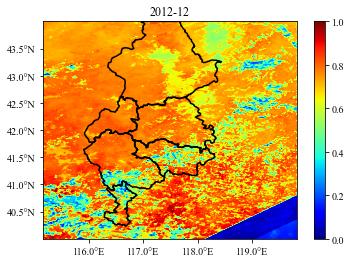

In [16]:
import matplotlib.ticker as mticker
from osgeo import ogr
TVDIFolder = r"Data\TVDIResult"
TVDINameList = os.listdir(TVDIFolder)
for i in range(len(TVDINameList)):
    print(TVDINameList[i][0:7])
    print("==========================")
    TVDIPath = TVDIFolder + "/" + TVDINameList[i]
    dataset = readTif(TVDIPath)
    width = dataset.RasterXSize #栅格矩阵的列数
    height = dataset.RasterYSize #栅格矩阵的行数
    TVDI = dataset.ReadAsArray(0,0,width,height)#获取数据
    Tif_geotrans = dataset.GetGeoTransform()
    Coords_UpperLeft = (Tif_geotrans[0], Tif_geotrans[3])
    Coords_BottomRight = (Tif_geotrans[0] + dataset.RasterXSize * Tif_geotrans[1] + dataset.RasterYSize * Tif_geotrans[2],
                          Tif_geotrans[3] + dataset.RasterYSize * Tif_geotrans[5] + dataset.RasterXSize * Tif_geotrans[4])
    
    #  设定图像的经纬度坐标范围，分别是左上角和右下角的坐标值范围，前两个是x坐标，后两个是y坐标
    extent = (Coords_UpperLeft[0], Coords_BottomRight[0], Coords_BottomRight[1], Coords_UpperLeft[1])
    plt.clf()
    sc = plt.imshow(TVDI, extent = extent, cmap = plt.cm.jet)# 设置cmap为RGB图
    #  正则化XY轴标签
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f°N'))
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f°E'))
    
    # 叠加矢量数据
    dsshp = ogr.Open(r"Data\Mask\BOUA.shp")
    layer = dsshp.GetLayer(0)
    for feature in layer:
        geom = feature.geometry()
        ring = geom.GetGeometryRef(0)
        coords = ring.GetPoints()
        x, y = zip(*coords)
        plt.plot(x, y, 'black')
    
    plt.colorbar()# 显示色度条
    plt.title(TVDINameList[i][0:7])
    plt.savefig("Data/TVDIRander/" + TVDINameList[i][0:7] + "_render.png", dpi=300)
    plt.show()